# Who deports more, Republicans or Democrats?


LIS MASc  
Everything Counts  
Assessment 2  
Student number: 24000114067

Access notebook online here: TODO

PDF generated using [nbconvert](https://nbconvert.readthedocs.io/en/latest/index.html)


## Introduction


Trump won the US election a few days ago. A surprising contingent of black and latino us citizens have voted for him. The idea being floated around regards the fact that while the biden presidency was better for the economy, people do not feel the economy.

I have been told the unlikely idea that the democrats deporting more than republicans - and this motivating latinos voting for trump even though that sounds contrary to their interests -. this would explain the latino votes for trump. it would mean that the voters care more about their personal situation than about the economy, and that they vote rationally instead of emotionally. assuming that trumps remarks about deporting legal immigrants and people eating cats and dogs wouldnt sit well with them, but
this would also point to trumps stuff as rhetoric that he doesnt actually do, but just says for the vibes.

While this is not motivated by academic literature, it is motivated by current events. In fact, understanding something of this, I would argue, is extremely important.

## Data sources

Office of Homeland Security data (deportation): https://ohss.dhs.gov/topics/immigration/yearbook/2019/table39

US House of Representatives History data (parties): https://history.house.gov/Institution/Presidents-Coinciding/Party-Government/

Statista - UN demographic data (population): https://www.statista.com/statistics/1067138/population-united-states-historical/


## Feature explanation


**Removal** is the compulsory movement of an undocumented immigrant out of the United States based on an order of removal.

**Returns** is the voluntary movement of an undocumented immigrant out of the United States without an order of removal.

An **unified** government is when the President's party holds the majority in both chambers.


## Research question

Is there a higher rate of deportation of undocumented immigrants in the US when the president is a Democrat?

TODO: source of this claim


## Hypothesis

H<sub>0</sub>: x̄<sub>D</sub> − x̄<sub>R</sub> = 0

H<sub>A</sub>: x̄<sub>D</sub> − x̄<sub>R</sub> ≠ 0

While the question is structured in a one-tailed way, if we need to ask this at all, it might be prudent to do a two-tailed test.


## Data cleaning


In [533]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.weightstats as st

pd.set_option("display.max_colwidth", None)
# pd.set_option('display.max_rows', 0)
pd.set_option('display.float_format', '{:,.2f}'.format)

# these are the colors google uses for their visualizations
gop_red = "#cf2035"
dem_blue = "#4d64ff"
custom_colors = sns.color_palette([dem_blue, gop_red])

plt.style.use("ggplot")
# plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 300

In [534]:
df = pd.read_csv("data/party.csv")
df.head()

,Congress,House Majority,Senate Majority,Presidency,Party Government
0,35th (1857–1859),Democrats,Democrats,Democrat (Buchanan),Unified
1,36th (1859–1861),Republicans,Democrats,Democrat (Buchanan),Divided
2,37th (1861–1863),Republicans,Republicans,Republican (Lincoln),Unified
3,38th (1863–1865),Republicans,Republicans,Republican (Lincoln),Unified
4,39th (1865–1867),Republicans,Republicans,Republican (Lincoln) / Democrat (A. Johnson),Unified / Divided


In [535]:
df.columns.to_list()

['Congress',
 'House Majority',
 'Senate Majority',
 'Presidency',
 'Party Government']

In [536]:
# rename columns
df = df.rename(
    columns={
        "Congress": "congress",
        "House Majority": "house_majority",
        "Senate Majority": "senate_majority",
        "Presidency": "presidency",
        "Party Government": "government",
    }
)

df.iloc[0]

congress               35th (1857–1859)
house_majority                Democrats
senate_majority               Democrats
presidency         Democrat (Buchanan) 
government                      Unified
Name: 0, dtype: object

### Missing values


In [537]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   congress         84 non-null     object
 1   house_majority   84 non-null     object
 2   senate_majority  84 non-null     object
 3   presidency       84 non-null     object
 4   government       84 non-null     object
dtypes: object(5)
memory usage: 32.2 KB


There are no missing values. However, when presidents resign or die, sometimes the vice-president is from the other party. Because of this complexity, we are dropping these cases. We keep the ones in which the two presidents are of the same party, as this shouldn't interfere with the analysis. This makes for very neat categories.


### Modifying features


#### Presidency


We move the president's name to another variable so the `presidency` feature can become a category.


In [538]:
df[["presidency", "president"]] = df["presidency"].str.extract(r"(.*)(\(.*\))")
df["president"] = df["president"].str.strip("()")
df.head()

,congress,house_majority,senate_majority,presidency,government,president
0,35th (1857–1859),Democrats,Democrats,Democrat,Unified,Buchanan
1,36th (1859–1861),Republicans,Democrats,Democrat,Divided,Buchanan
2,37th (1861–1863),Republicans,Republicans,Republican,Unified,Lincoln
3,38th (1863–1865),Republicans,Republicans,Republican,Unified,Lincoln
4,39th (1865–1867),Republicans,Republicans,Republican (Lincoln) / Democrat,Unified / Divided,A. Johnson


In [539]:
df["presidency"] = df["presidency"].astype("category")

#### Congress


In a similar but more involved way, we extract the years from the congress feature. The point is to have one row per year so that we can fit the two tables together.

We assume that if the 35th congress spans 1857-1859 and the 36th spans 1859-1861, the end result should be:

| Year | Congress |
| ---- | -------- |
| 1857 | 35th     |
| 1858 | 35th     |
| 1859 | 36th     |
| 1860 | 36th     |


In [540]:
df[["congress", "year_start", "year_end"]] = df["congress"].str.extract(
    r"^(\d*)\w{2} \((.*)–(.*)\)"
)
df.iloc[0]

congress                  35
house_majority     Democrats
senate_majority    Democrats
presidency         Democrat 
government           Unified
president           Buchanan
year_start              1857
year_end                1859
Name: 0, dtype: object

In [541]:
new_rows = []
for k, v in df.iterrows():
    for i in range(int(v["year_start"]), int(v["year_end"])):
        new_row = v.copy()
        new_row["year"] = i
        new_rows.append(new_row)

df = pd.DataFrame(new_rows)
df = df.drop(columns=["year_start", "year_end"])

In [542]:
df.sort_values(by="year")

,congress,house_majority,senate_majority,presidency,government,president,year
0,35,Democrats,Democrats,Democrat,Unified,Buchanan,1857
0,35,Democrats,Democrats,Democrat,Unified,Buchanan,1858
1,36,Republicans,Democrats,Democrat,Divided,Buchanan,1859
1,36,Republicans,Democrats,Democrat,Divided,Buchanan,1860
2,37,Republicans,Republicans,Republican,Unified,Lincoln,1861
...,...,...,...,...,...,...,...
81,116,Democrats,Republicans,Republican,Divided,Trump,2020
82,117,Democrats,Democrats,Democrat,Unified,Biden,2021
82,117,Democrats,Democrats,Democrat,Unified,Biden,2022
83,118,Republicans,Democrats,Democrat,Divided,Biden,2023


### Categories


In [543]:
df["house_majority"].value_counts()

house_majority
Democrats      94
Republicans    74
Name: count, dtype: int64

In [544]:
df["government"].value_counts()

government
Unified              92
Divided              72
Unified / Divided     4
Name: count, dtype: int64

In [545]:
df.loc[df["government"] == "Unified / Divided"]

,congress,house_majority,senate_majority,presidency,government,president,year
4,39,Republicans,Republicans,Republican (Lincoln) / Democrat,Unified / Divided,A. Johnson,1865
4,39,Republicans,Republicans,Republican (Lincoln) / Democrat,Unified / Divided,A. Johnson,1866
72,107,Republicans,Republicans / Democrats,Republican,Unified / Divided,G.W. Bush,2001
72,107,Republicans,Republicans / Democrats,Republican,Unified / Divided,G.W. Bush,2002


In [546]:
complicated = df["government"] == "Unified / Divided"
df = df[~complicated]

In [547]:
df["government"].value_counts()

government
Unified    92
Divided    72
Name: count, dtype: int64

In [548]:
df["senate_majority"].value_counts()

senate_majority
Republicans    86
Democrats      78
Name: count, dtype: int64

In [549]:
category_cols = ["house_majority", "senate_majority", "government", "presidency"]

df[category_cols] = df[category_cols].astype("category")

In [550]:
df["congress"] = df["congress"].astype("int")

Now we have nice columns and categories to group our numerical data by.


#### Rename categories


We change 'Democrats' to 'Democrat' so all categories between columns are standardized.


In [551]:
df["house_majority"] = df["house_majority"].cat.rename_categories(
    {
        "Democrats": "Democrat",
        "Republicans": "Republican",
    }
)
df["house_majority"].cat.categories

Index(['Democrat', 'Republican'], dtype='object')

In [552]:
df["senate_majority"] = df["senate_majority"].cat.rename_categories(
    {
        "Democrats": "Democrat",
        "Republicans": "Republican",
    }
)
df["senate_majority"].cat.categories

Index(['Democrat', 'Republican'], dtype='object')

In [553]:
df["presidency"] = df["presidency"].cat.rename_categories(
    {
        "Democrat ": "Democrat",
        "Republican ": "Republican",
    }
)
df["presidency"].cat.categories

Index(['Democrat', 'Republican'], dtype='object')

In [554]:
df["government"].cat.categories

Index(['Divided', 'Unified'], dtype='object')

### Adding deportation data


Here we get the deportation data and join it with the dataframe. This is why it was critical to generate the year feature.


In [555]:
df2 = pd.read_csv("data/ice.csv")
df2.head()

,year,removals,returns
0,2019,359885,"171,445.00"
1,2018,328716,"159,940.00"
2,2017,287093,"100,695.00"
3,2016,331717,"106,458.00"
4,2015,325328,"129,661.00"


In [556]:
df = pd.merge(df, df2, on="year")
df.head()

,congress,house_majority,senate_majority,presidency,government,president,year,removals,returns
0,52,Democrat,Republican,Republican,Divided,Harrison,1892,2801,NaN
1,53,Democrat,Democrat,Democrat,Unified,Cleveland,1893,1630,NaN
2,53,Democrat,Democrat,Democrat,Unified,Cleveland,1894,1806,NaN
3,54,Republican,Republican,Democrat,Divided,Cleveland,1895,2596,NaN
4,54,Republican,Republican,Democrat,Divided,Cleveland,1896,3037,NaN


In [557]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   congress         126 non-null    int64   
 1   house_majority   126 non-null    category
 2   senate_majority  126 non-null    category
 3   presidency       126 non-null    category
 4   government       126 non-null    category
 5   president        126 non-null    object  
 6   year             126 non-null    int64   
 7   removals         126 non-null    int64   
 8   returns          91 non-null     float64 
dtypes: category(4), float64(1), int64(3), object(1)
memory usage: 13.6 KB


We keep the retuns as floats because the NaNs are significant -- they refer to the period before removals and returns were considered as different categories.


### Adding population data

Comparing the absolute values of deportation might be meaningless since the population of the country changes a lot with time. The new governments might have higher deportation rates simply because they have more people. Because of this, we create adjusted metrics that account for the population growth

In [558]:
df3 = pd.read_csv("data/population.csv")
df3

,year,population
0,1800,"6,000"
1,1801,"6,110"
2,1802,"6,230"
3,1803,"6,350"
4,1804,"6,470"
...,...,...
216,2016,"323,015.99"
217,2017,"325,084.76"
218,2018,"327,096.26"
219,2019,"329,064.92"


In [559]:
df3['population'] = df3['population'].str.replace(",", "")
df3['population'] = df3['population'].astype('float')
df3['population'] = df3['population'] * 1000
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        221 non-null    int64  
 1   population  221 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.6 KB


In [560]:
df = pd.merge(df, df3, on="year")
df.tail()

,congress,house_majority,senate_majority,presidency,government,president,year,removals,returns,population
121,114,Republican,Republican,Democrat,Divided,Obama,2015,325328,"129,661.00","320,878,310.00"
122,114,Republican,Republican,Democrat,Divided,Obama,2016,331717,"106,458.00","323,015,990.00"
123,115,Republican,Republican,Republican,Unified,Trump,2017,287093,"100,695.00","325,084,760.00"
124,115,Republican,Republican,Republican,Unified,Trump,2018,328716,"159,940.00","327,096,260.00"
125,116,Democrat,Republican,Republican,Divided,Trump,2019,359885,"171,445.00","329,064,920.00"


In [561]:
df['removals_adj'] = df['removals'] / df['population']
df['returns_adj'] = df['returns'] / df['population']
df.tail()

,congress,house_majority,senate_majority,presidency,government,president,year,removals,returns,population,removals_adj,returns_adj
121,114,Republican,Republican,Democrat,Divided,Obama,2015,325328,"129,661.00","320,878,310.00",0.00,0.00
122,114,Republican,Republican,Democrat,Divided,Obama,2016,331717,"106,458.00","323,015,990.00",0.00,0.00
123,115,Republican,Republican,Republican,Unified,Trump,2017,287093,"100,695.00","325,084,760.00",0.00,0.00
124,115,Republican,Republican,Republican,Unified,Trump,2018,328716,"159,940.00","327,096,260.00",0.00,0.00
125,116,Democrat,Republican,Republican,Divided,Trump,2019,359885,"171,445.00","329,064,920.00",0.00,0.00


Finally, we reorder the columns.


In [562]:
df.columns.to_list()

['congress',
 'house_majority',
 'senate_majority',
 'presidency',
 'government',
 'president',
 'year',
 'removals',
 'returns',
 'population',
 'removals_adj',
 'returns_adj']

In [563]:
# reorder columns
df = df[
    [
        "year",
        "congress",
        "president",
        "presidency",
        "house_majority",
        "senate_majority",
        "government",
        'population',
        'removals',
        'removals_adj',
        'returns',
        'returns_adj',
    ]
]

In [564]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   year             126 non-null    int64   
 1   congress         126 non-null    int64   
 2   president        126 non-null    object  
 3   presidency       126 non-null    category
 4   house_majority   126 non-null    category
 5   senate_majority  126 non-null    category
 6   government       126 non-null    category
 7   population       126 non-null    float64 
 8   removals         126 non-null    int64   
 9   removals_adj     126 non-null    float64 
 10  returns          91 non-null     float64 
 11  returns_adj      91 non-null     float64 
dtypes: category(4), float64(4), int64(3), object(1)
memory usage: 16.5 KB


## Descriptive statistics


In [565]:
df.head()

,year,congress,president,presidency,house_majority,senate_majority,government,population,removals,removals_adj,returns,returns_adj
0,1892,52,Harrison,Republican,Democrat,Republican,Divided,"67,400,000.00",2801,0.00,NaN,NaN
1,1893,53,Cleveland,Democrat,Democrat,Democrat,Unified,"68,700,000.00",1630,0.00,NaN,NaN
2,1894,53,Cleveland,Democrat,Democrat,Democrat,Unified,"70,100,000.00",1806,0.00,NaN,NaN
3,1895,54,Cleveland,Democrat,Republican,Republican,Divided,"71,500,000.00",2596,0.00,NaN,NaN
4,1896,54,Cleveland,Democrat,Republican,Republican,Divided,"72,900,000.00",3037,0.00,NaN,NaN


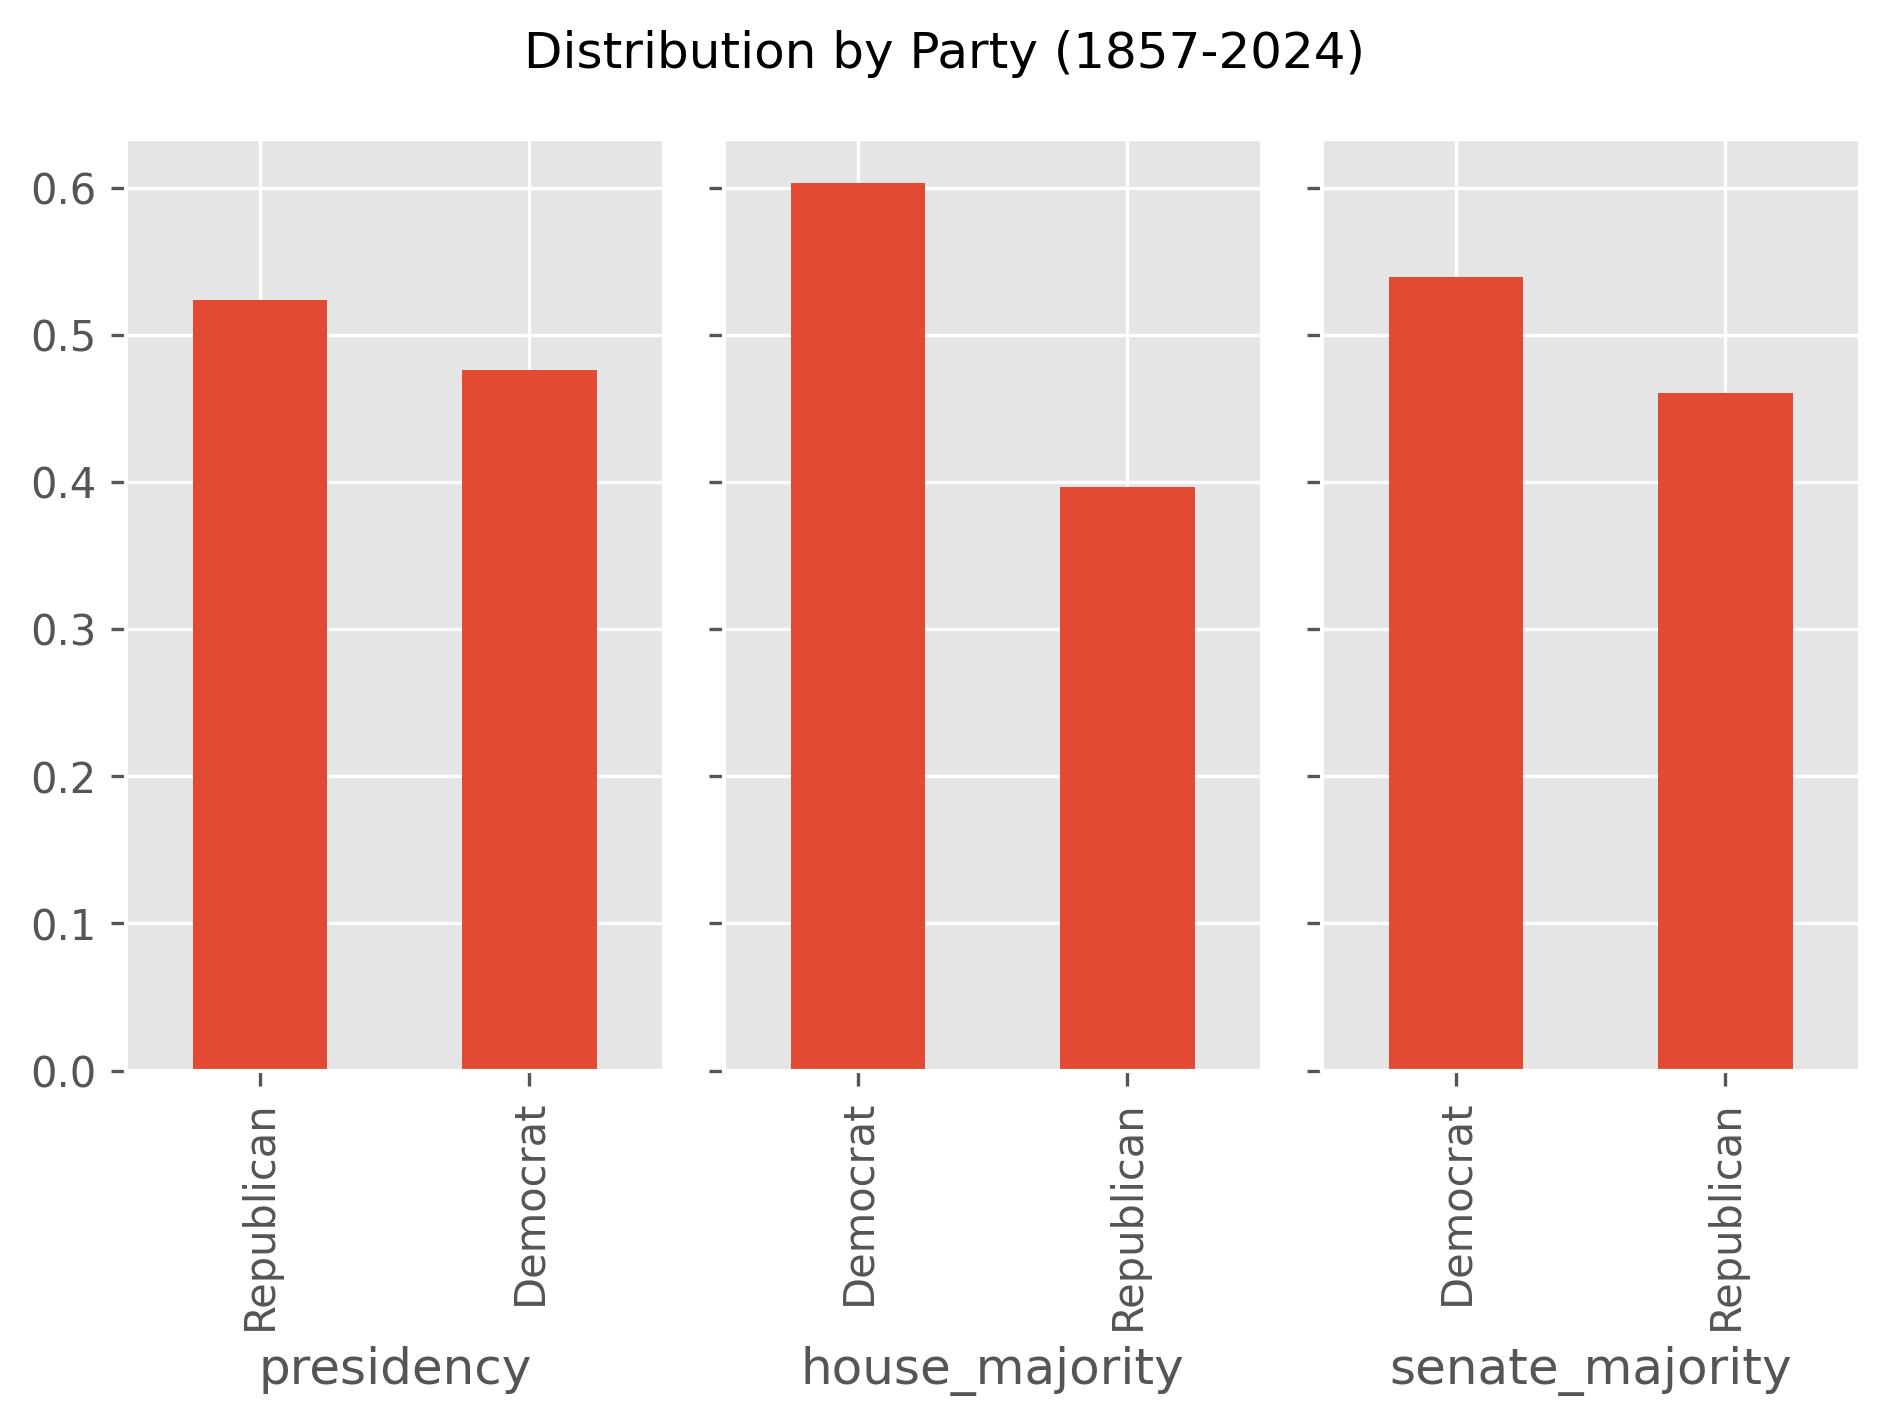

In [566]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

df["presidency"].value_counts(normalize=True).plot(
    ax=axes[0], kind="bar", stacked=True, ylabel=""
)

df["house_majority"].value_counts(normalize=True).plot(
    ax=axes[1], kind="bar", stacked=True, ylabel=""
)
df["senate_majority"].value_counts(normalize=True).plot(
    ax=axes[2], kind="bar", stacked=True, ylabel=""
)

plt.suptitle("Distribution by Party (1857-2024)")
plt.tight_layout()

<Axes: ylabel='government'>

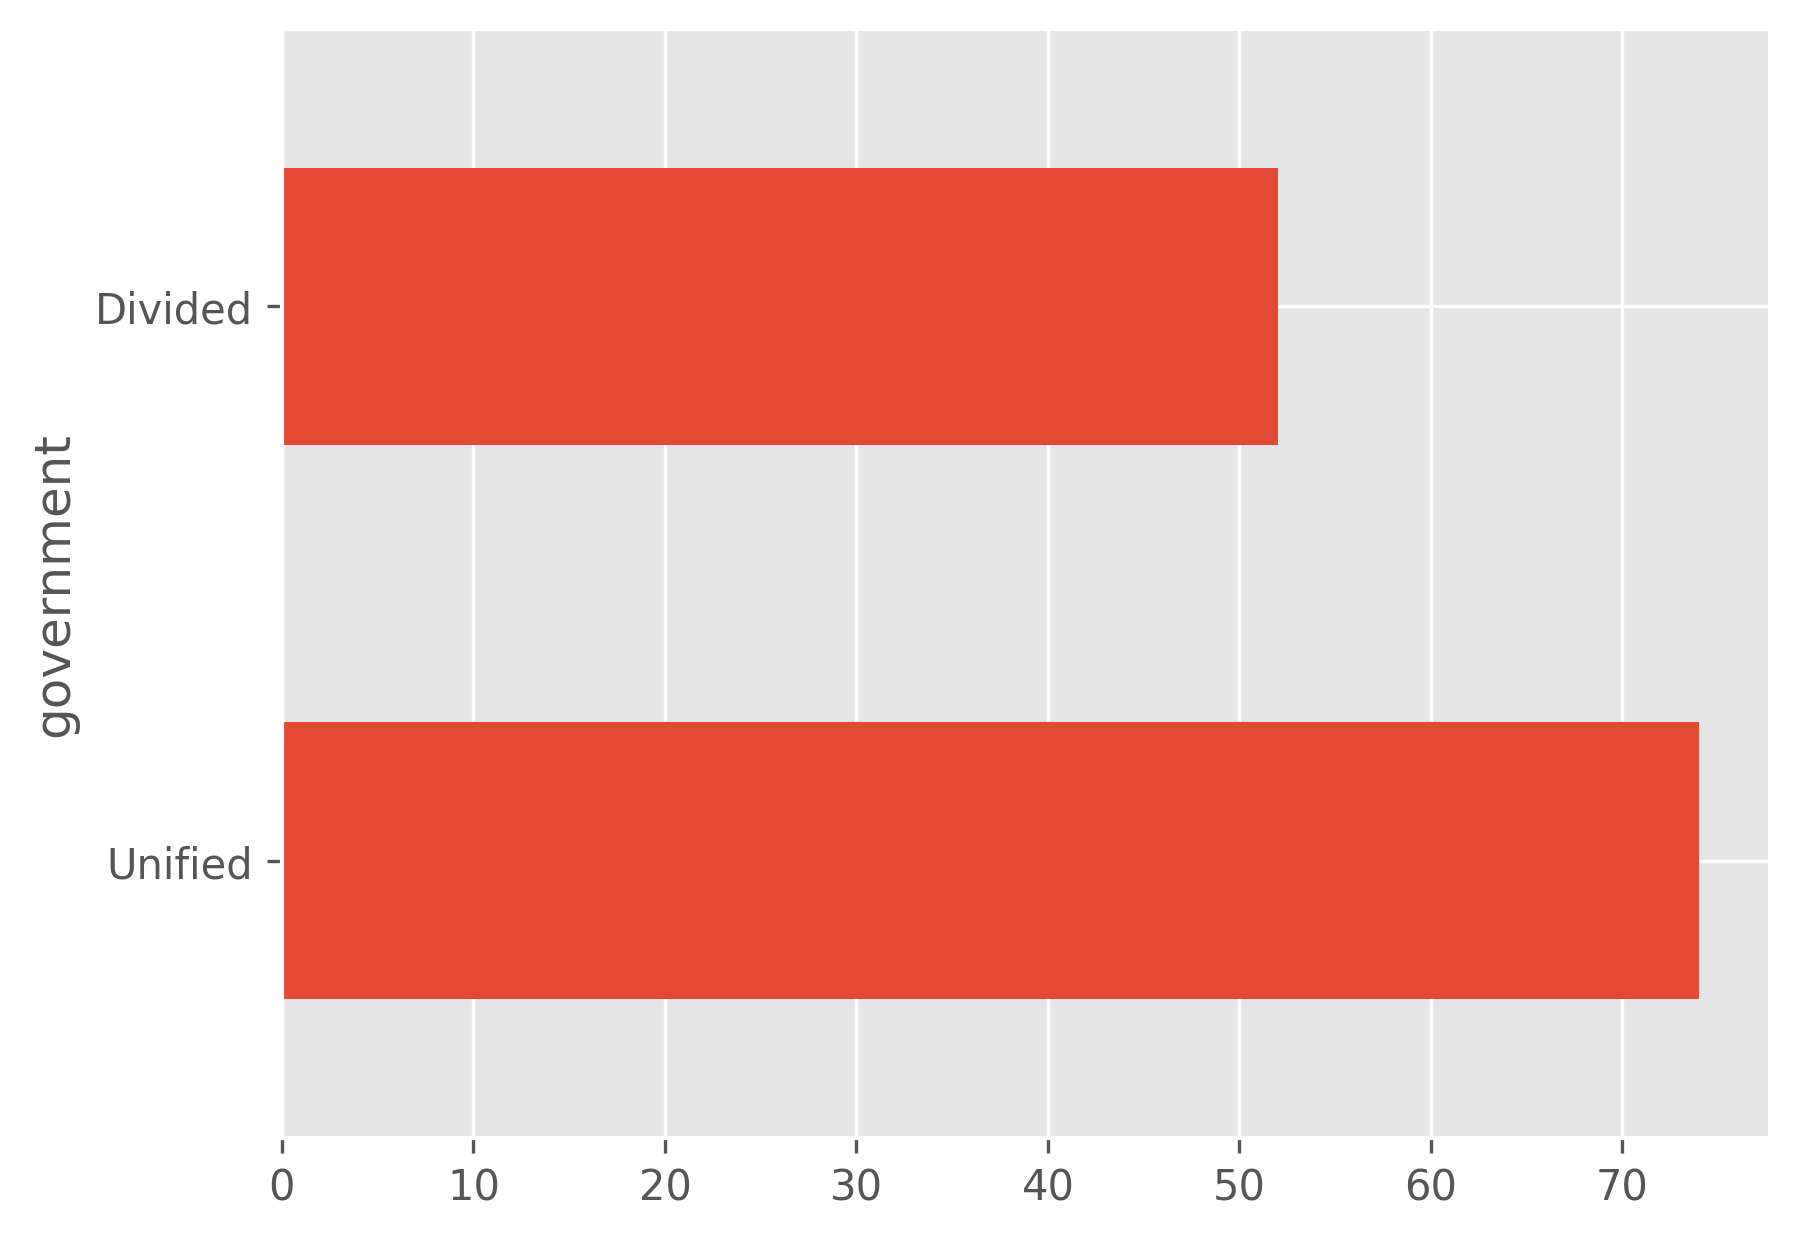

In [567]:
df["government"].value_counts().plot.barh()

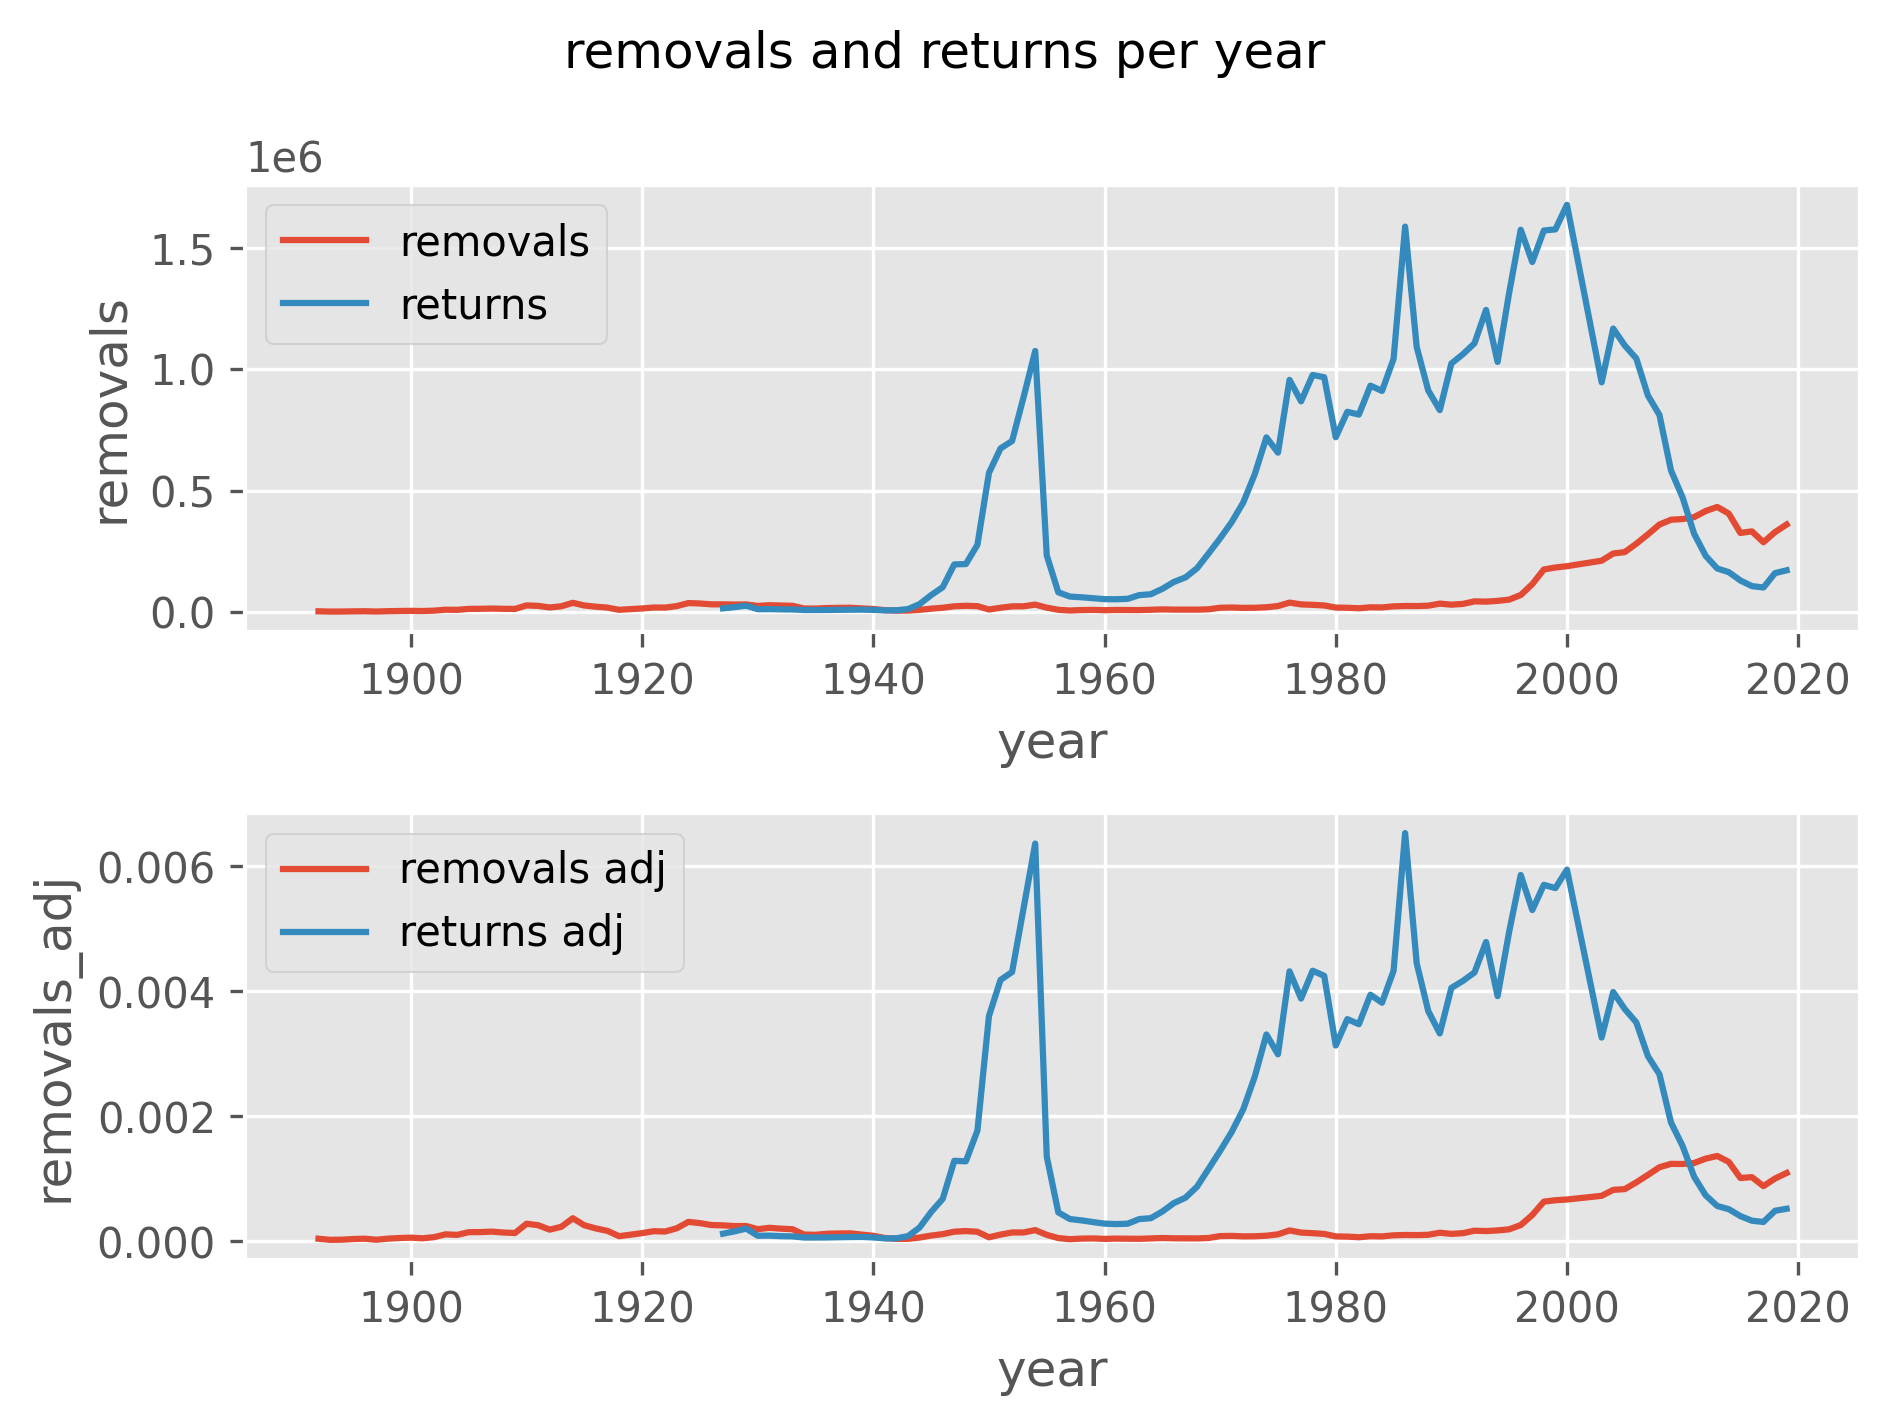

In [568]:
fig, axes = plt.subplots(2, 1)

sns.lineplot(data=df, ax=axes[0], x="year", y="removals", label="removals")
sns.lineplot(data=df, ax=axes[0], x="year", y="returns", label="returns")

sns.lineplot(data=df, ax=axes[1], x="year", y="removals_adj", label="removals adj")
sns.lineplot(data=df, ax=axes[1], x="year", y="returns_adj", label="returns adj")

plt.legend()
plt.suptitle("removals and returns per year")
plt.tight_layout()

By looking at it, it seems that adjusting for the population only makes the deportations from before 1960 seem a bit more expressive. Apart from that, there is no difference. This might be because the population growth looks like a straight 45 degree angle line. 

The expectation that population would be important here seems to be false. I thought that it might be misleading but as it is I have no reason to believe it is.

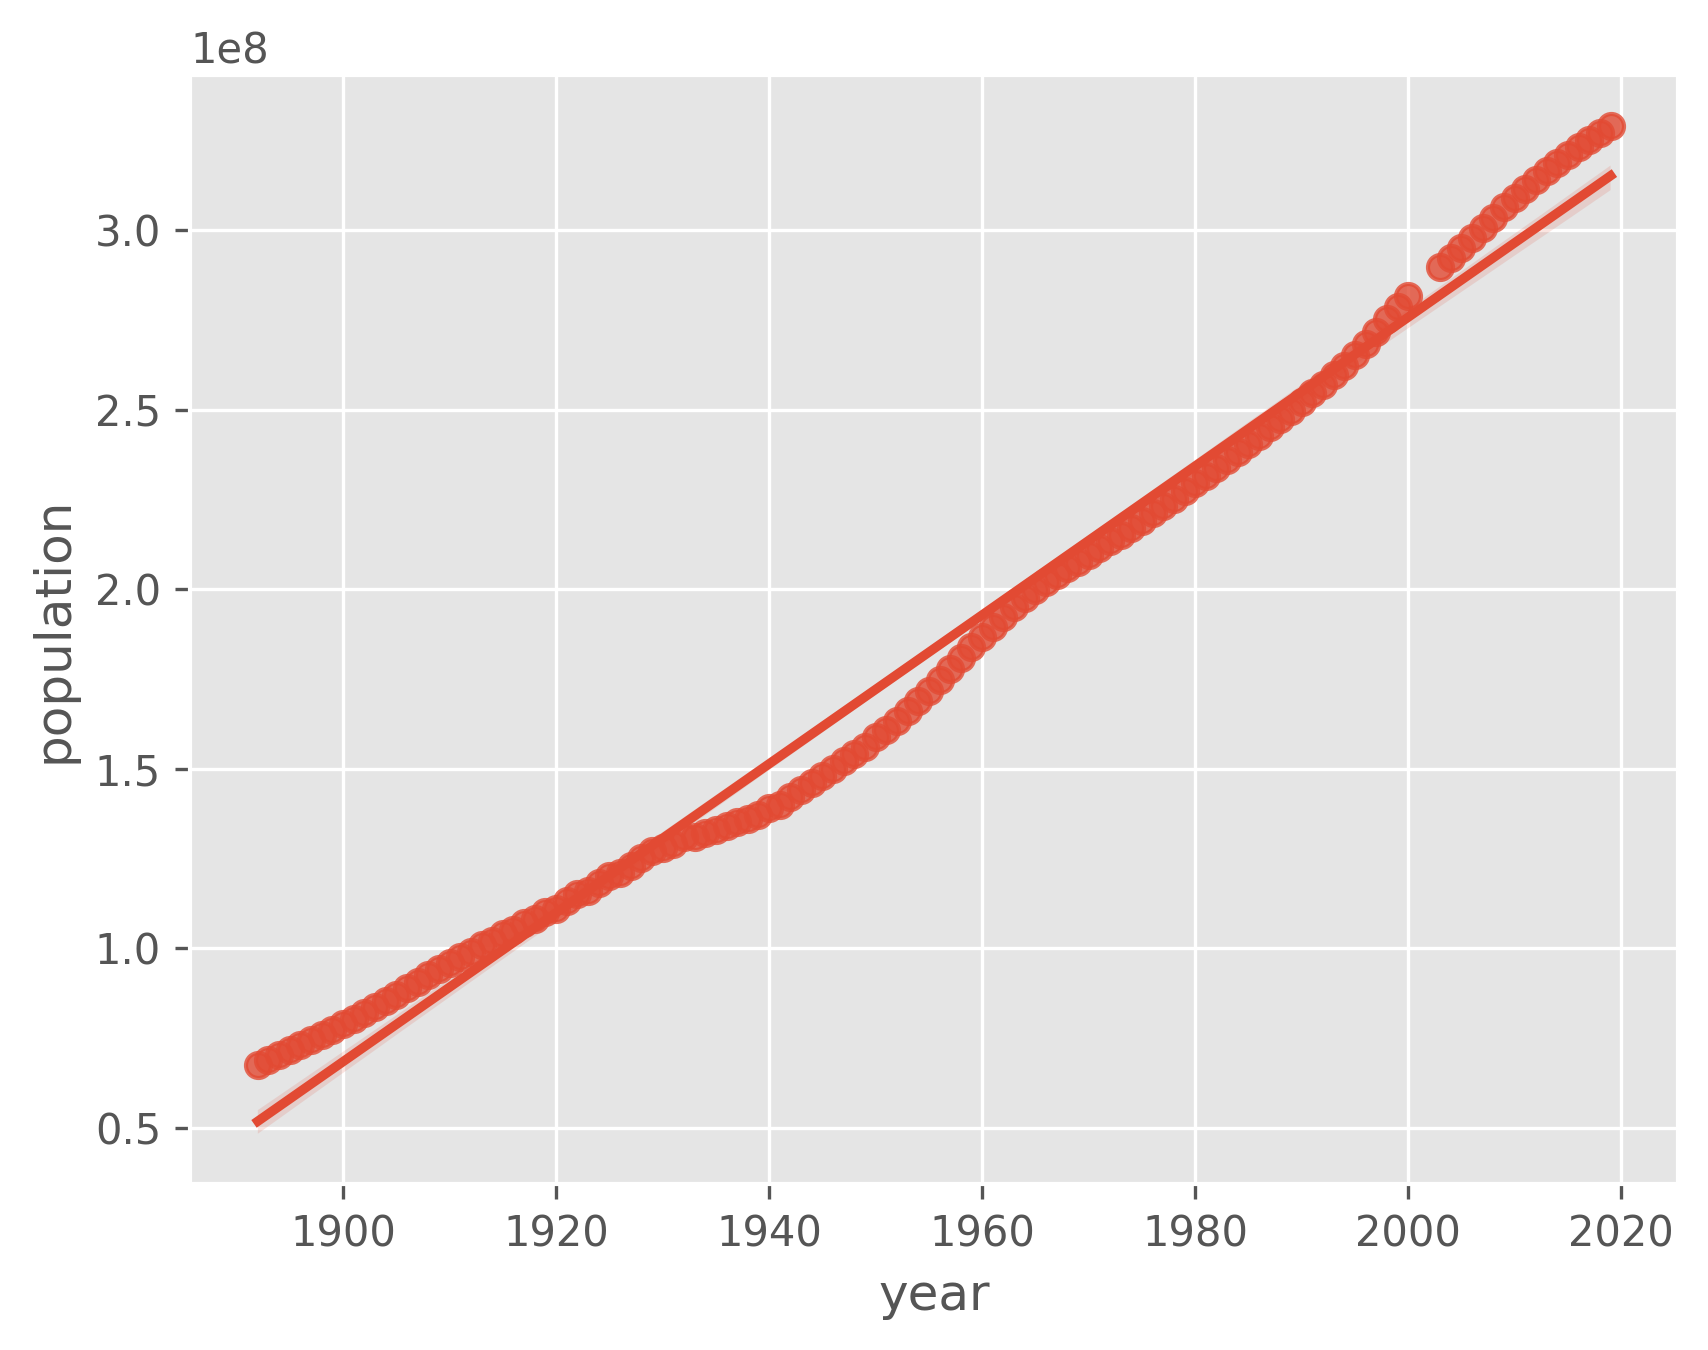

In [607]:
sns.regplot(data=df, x="year", y="population");

In [604]:
df[['removals', 'removals_adj']].corr()

,removals,removals_adj
removals,1.00,0.99
removals_adj,0.99,1.00


Between that and the fact that the adjusted metric has a 99% correlation with the original, this line of inquiry is dropped.

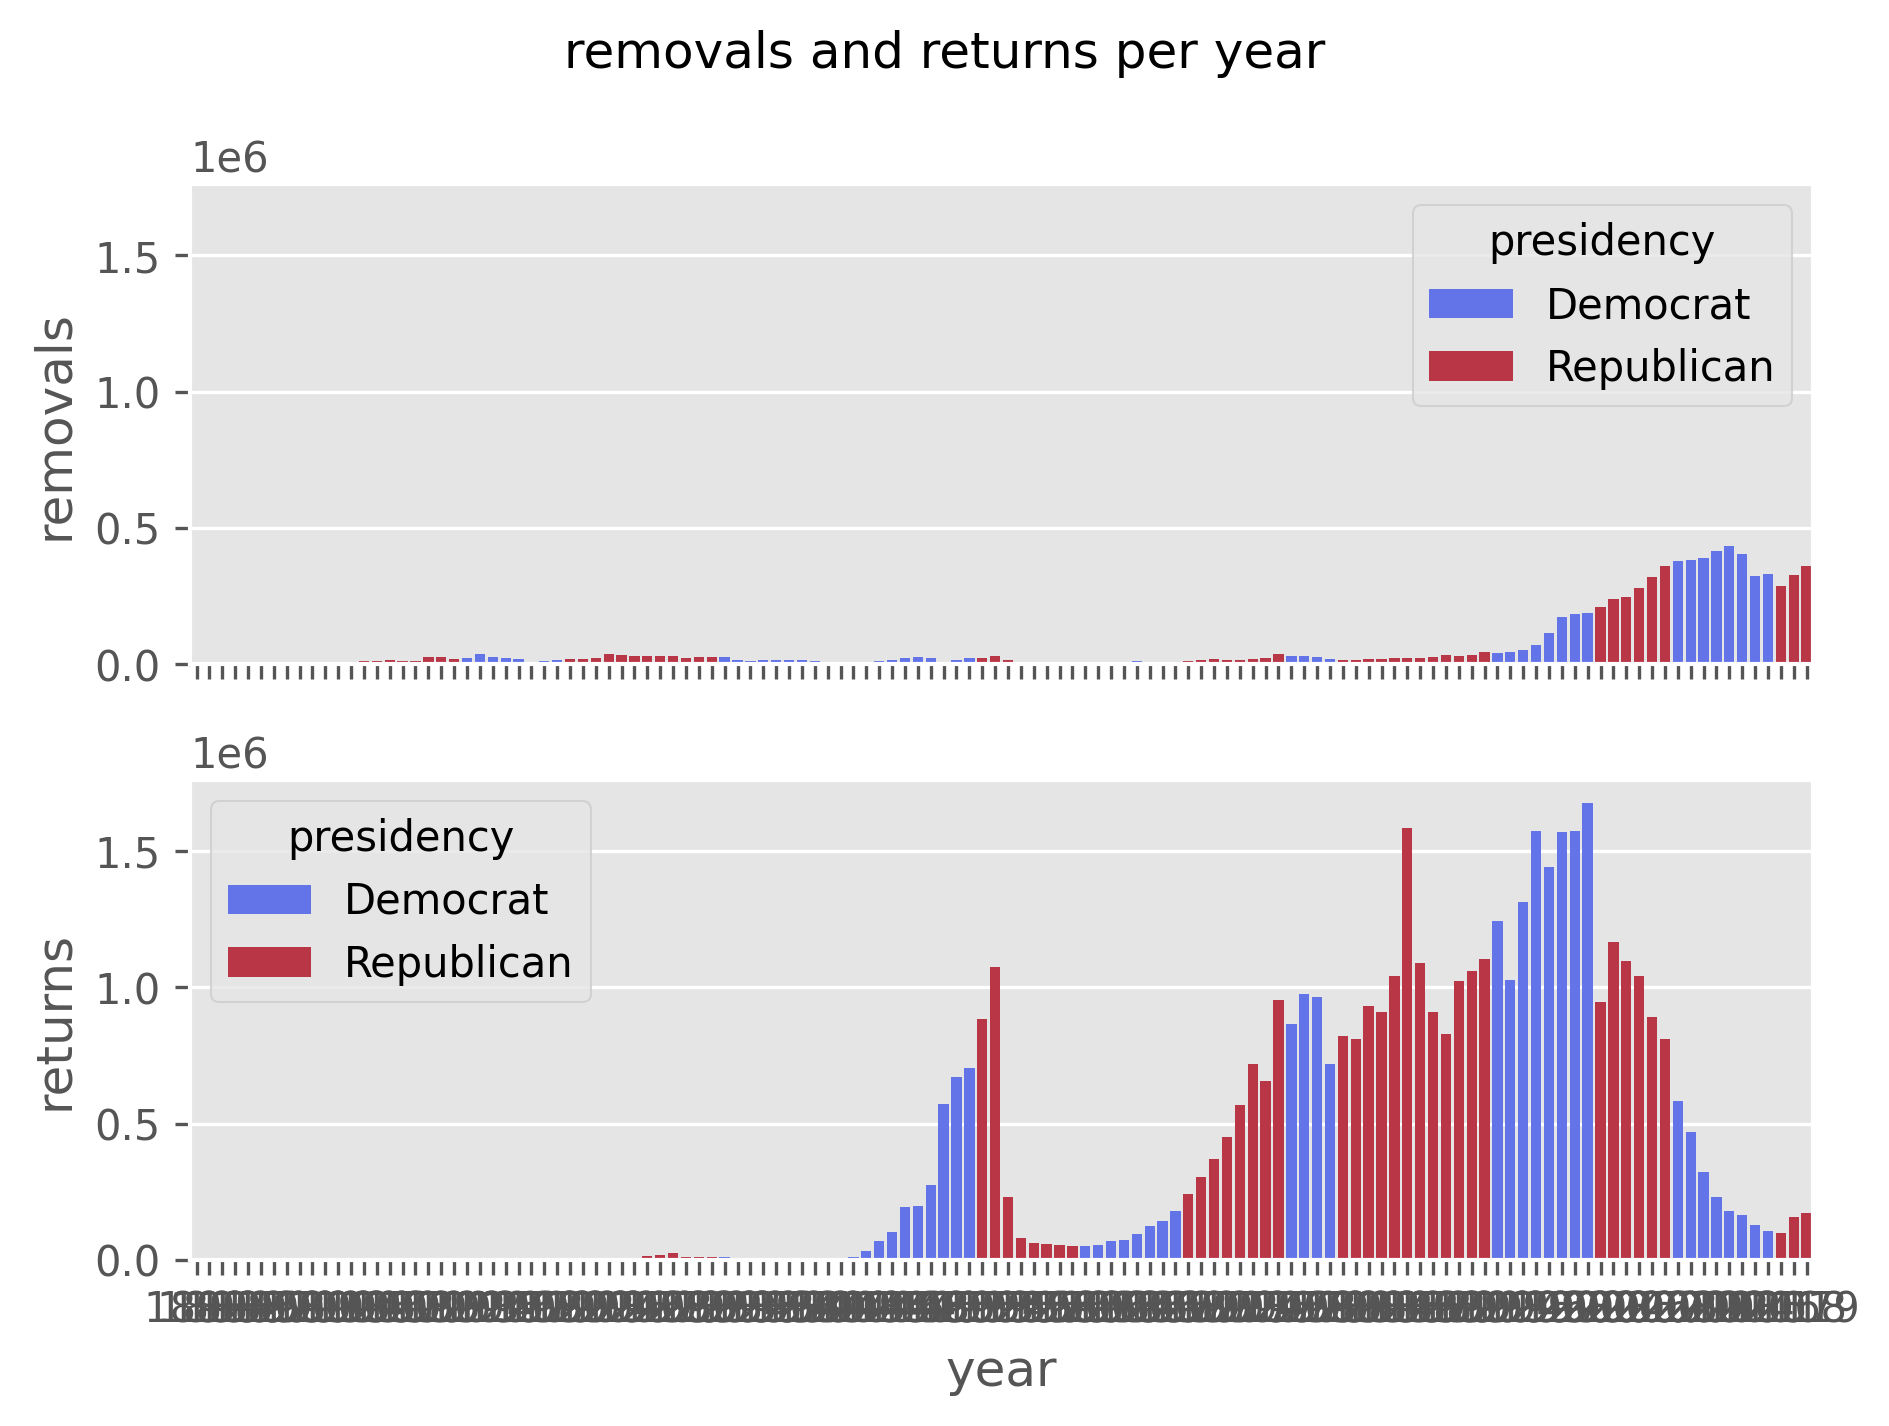

In [610]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)

sns.barplot(
    data=df,
    ax=axes[0],
    x="year",
    y="removals",
    hue="presidency",
    palette=custom_colors,
)

sns.barplot(
    data=df,
    ax=axes[1],
    x="year",
    y="returns",
    hue="presidency",
    palette=custom_colors,
)

plt.suptitle("removals and returns per year")
plt.tight_layout()

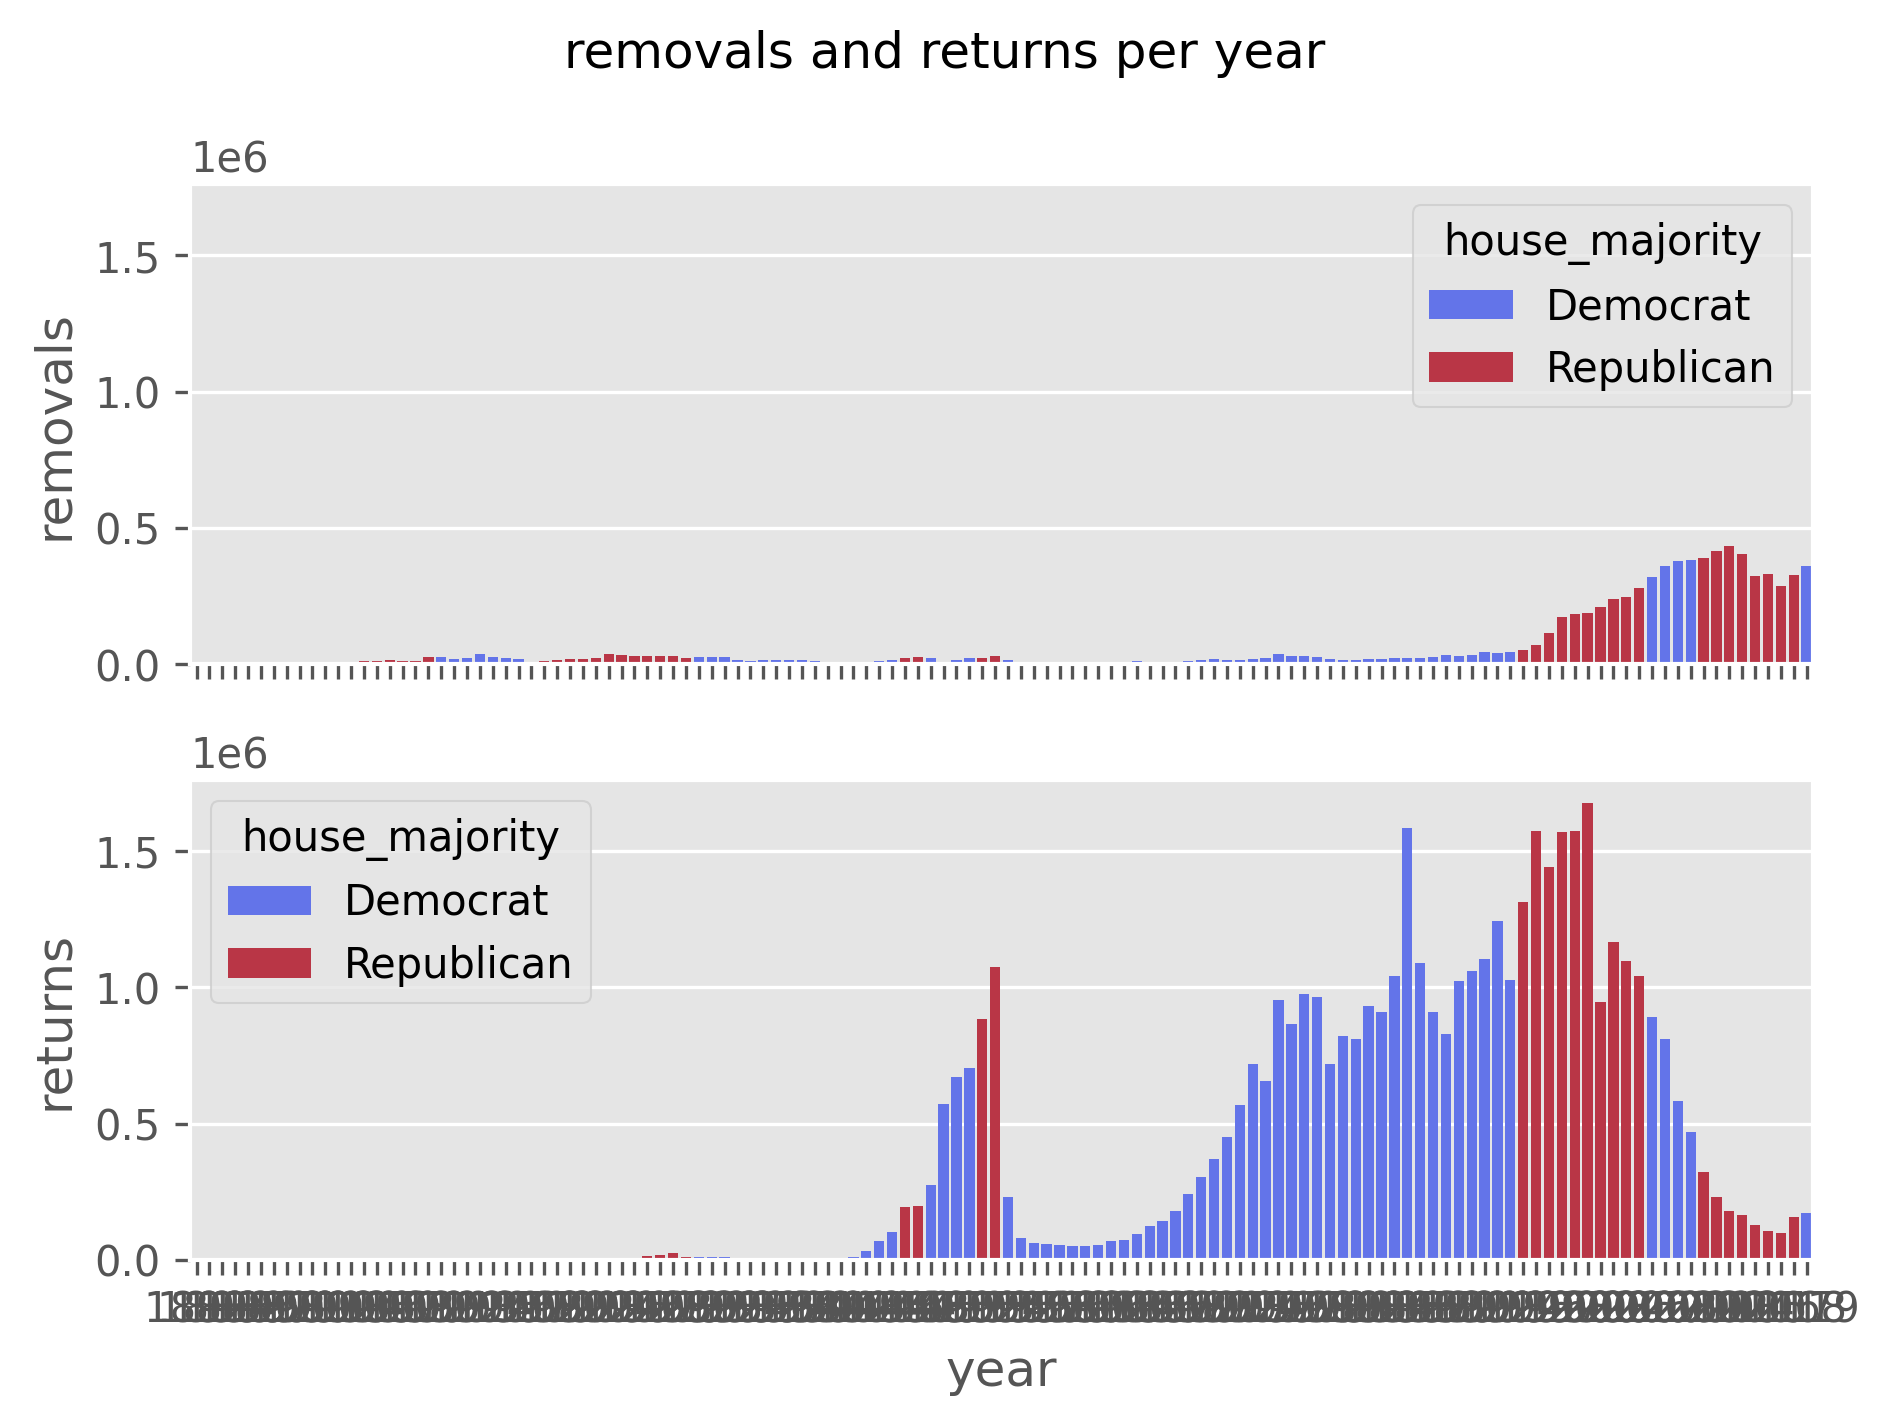

In [616]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)

sns.barplot(
    data=df,
    ax=axes[0],
    x="year",
    y="removals",
    hue="house_majority",
    palette=custom_colors,
)

sns.barplot(
    data=df,
    ax=axes[1],
    x="year",
    y="returns",
    hue="house_majority",
    palette=custom_colors,
)

plt.suptitle("removals and returns per year")
plt.tight_layout()

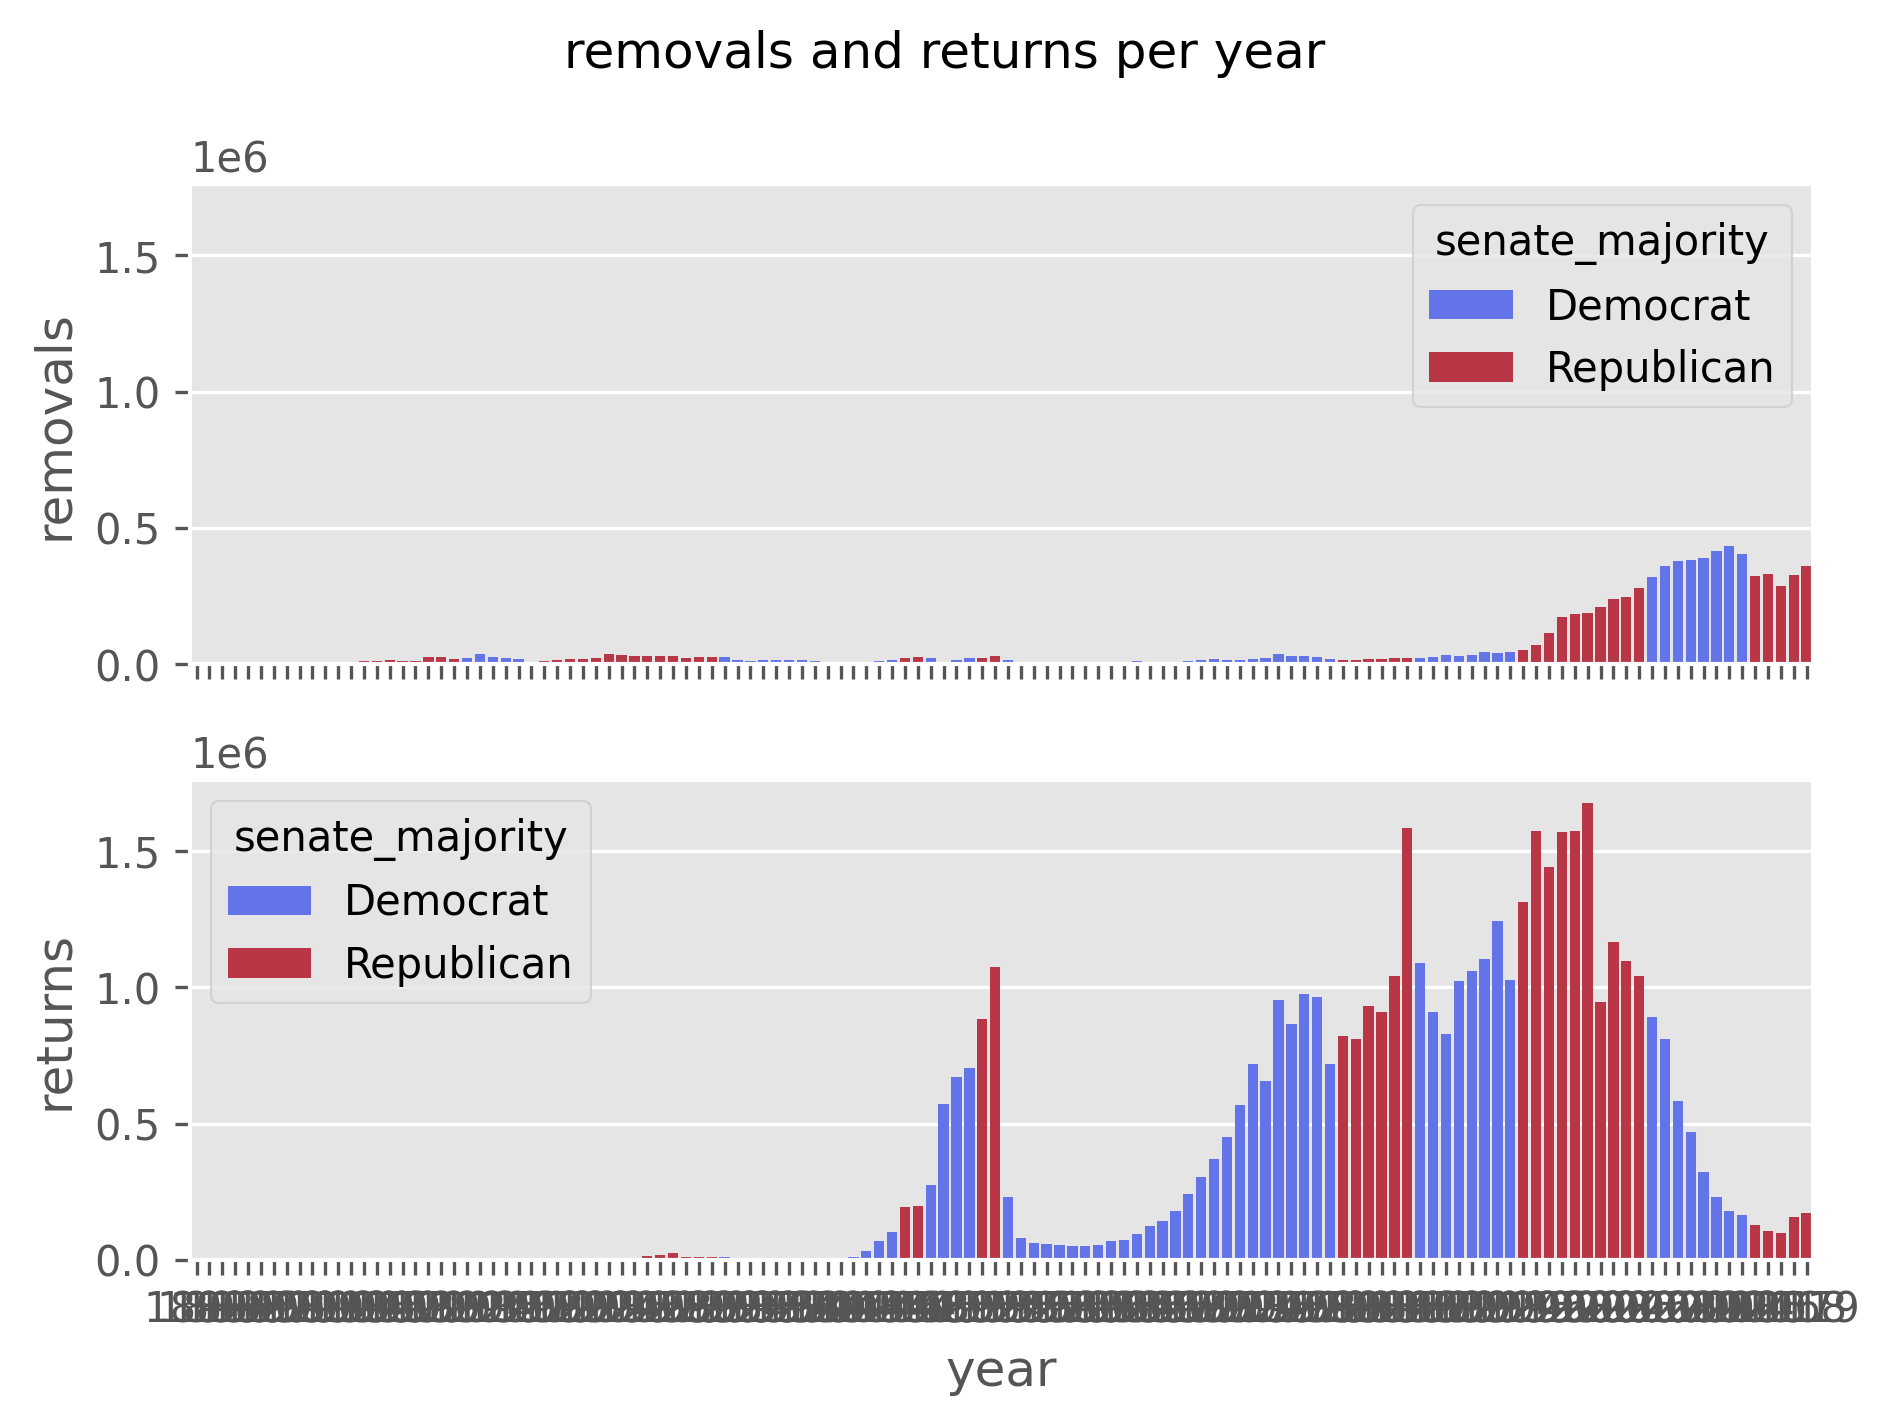

In [613]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)

sns.barplot(
    data=df,
    ax=axes[0],
    x="year",
    y="removals",
    hue="senate_majority",
    palette=custom_colors,
)

sns.barplot(
    data=df,
    ax=axes[1],
    x="year",
    y="returns",
    hue="senate_majority",
    palette=custom_colors,
)

plt.suptitle("removals and returns per year")
plt.tight_layout()

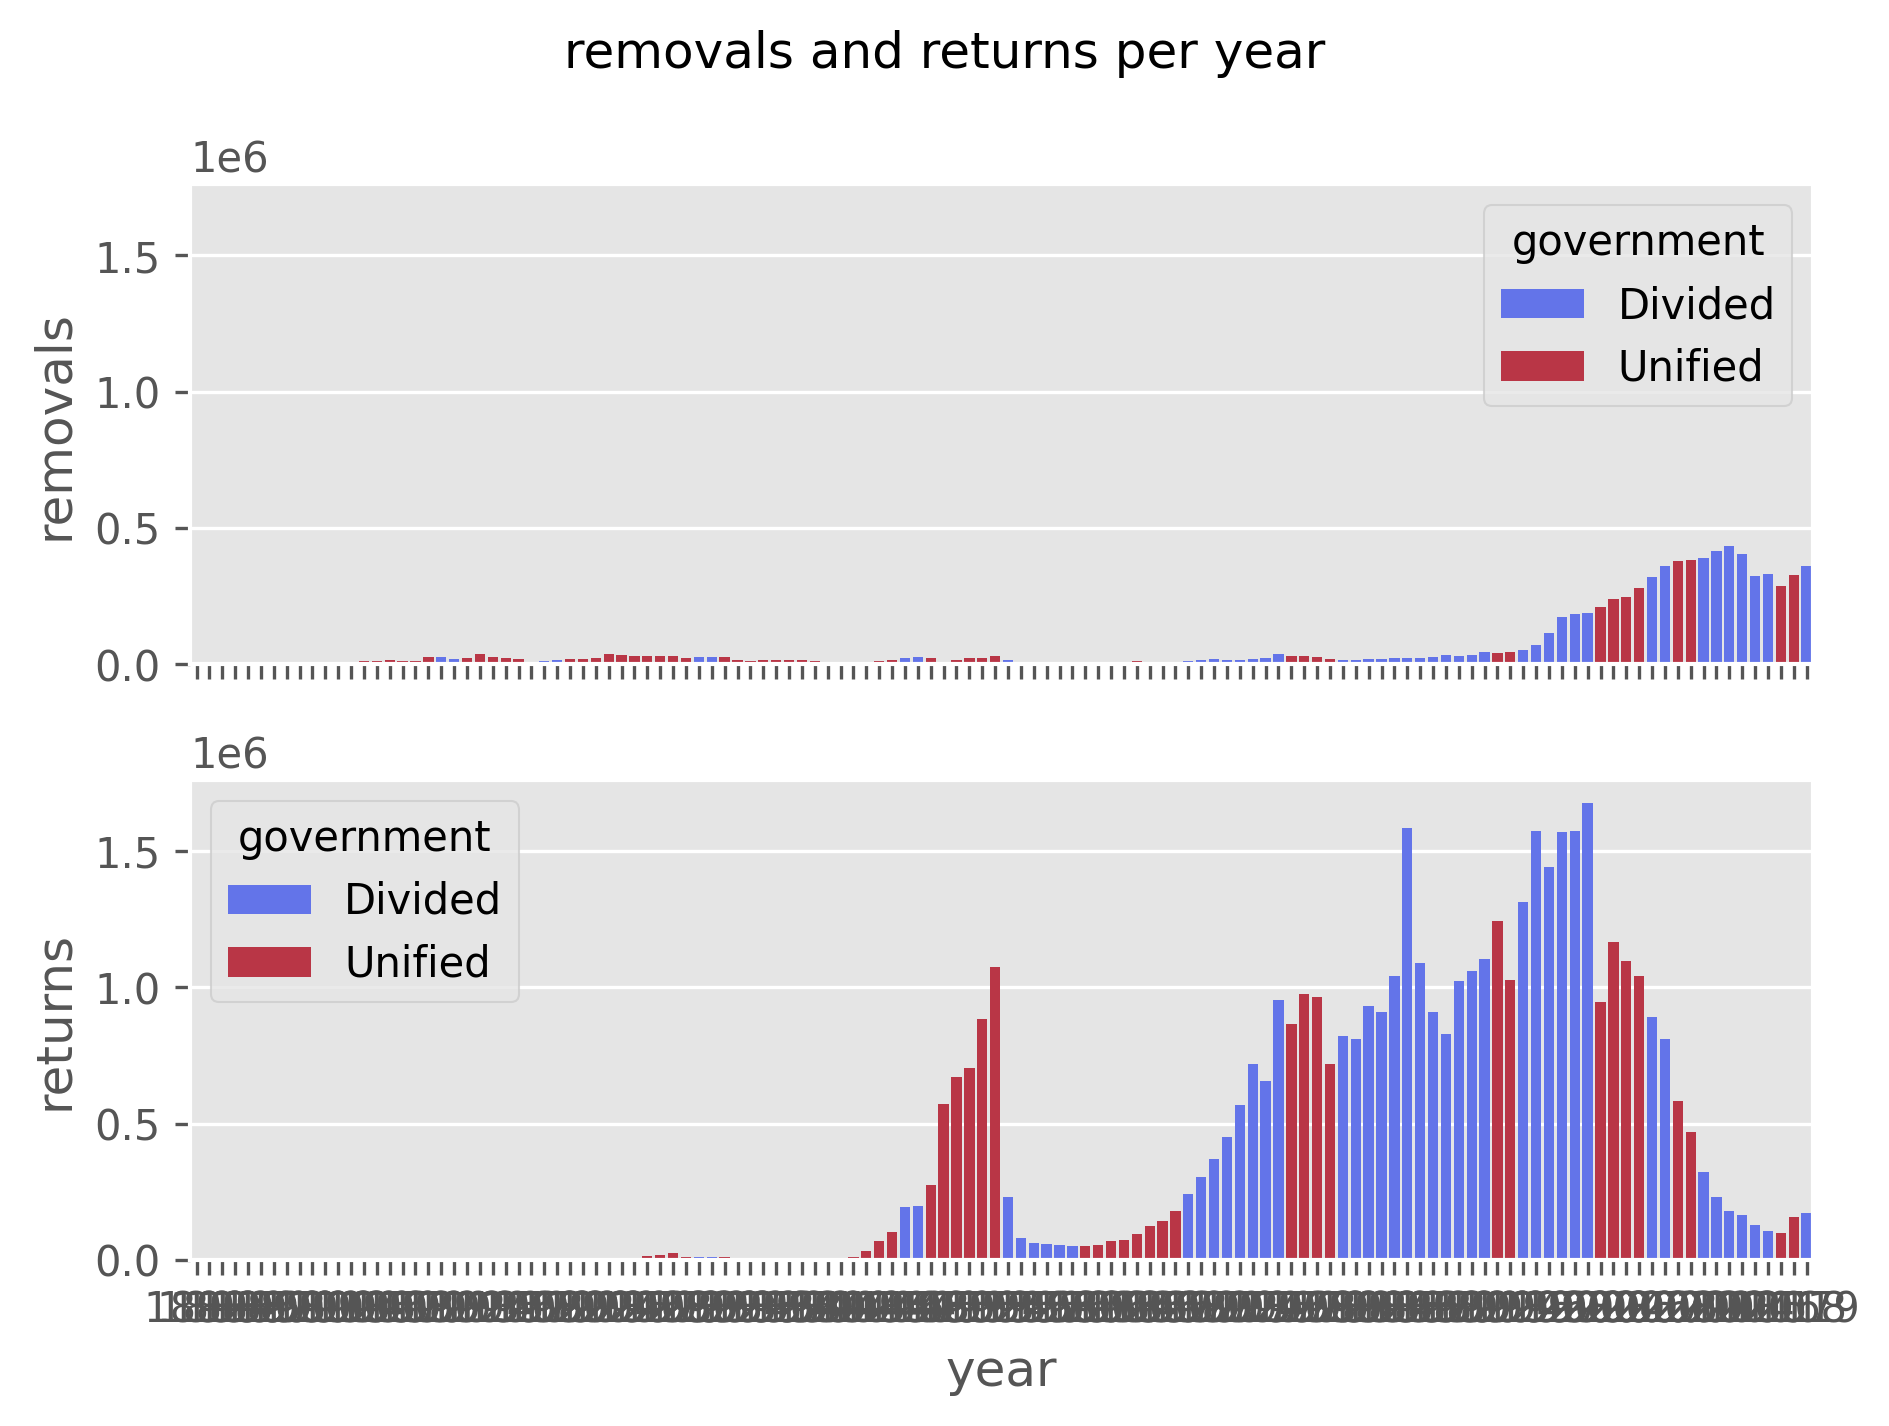

In [614]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)

sns.barplot(
    data=df,
    ax=axes[0],
    x="year",
    y="removals",
    hue="government",
    palette=custom_colors,
)

sns.barplot(
    data=df,
    ax=axes[1],
    x="year",
    y="returns",
    hue="government",
    palette=custom_colors,
)

plt.suptitle("removals and returns per year")
plt.tight_layout()

This plot also showcases how returns dropped suddenly while removals increased in the last few decades. Looking at them I do not get the impression that party has something to do with deportation numbers.

In [571]:
print(f'{df["removals"].sum():,} total removals')
print(f'{df["returns"].sum():,} total returns')
print(f'{df["returns"].sum() / df["removals"].sum():.2f}x more returns than removals')

8,327,152 total removals
46,224,954.0 total returns
5.55x more returns than removals


In [572]:
df.sort_values(by="returns", ascending=False).head(20)

,year,congress,president,presidency,house_majority,senate_majority,government,population,removals,removals_adj,returns,returns_adj
108,2000,106,Clinton,Democrat,Republican,Republican,Divided,"281,710,910.00",188467,0.00,"1,675,876.00",0.01
94,1986,99,Reagan,Republican,Democrat,Republican,Divided,"242,763,140.00",24592,0.00,"1,586,320.00",0.01
107,1999,106,Clinton,Democrat,Republican,Republican,Divided,"278,548,150.00",183114,0.00,"1,574,863.00",0.01
104,1996,104,Clinton,Democrat,Republican,Republican,Divided,"268,335,010.00",69680,0.00,"1,573,428.00",0.01
106,1998,105,Clinton,Democrat,Republican,Republican,Divided,"275,175,310.00",174813,0.00,"1,570,127.00",0.01
105,1997,105,Clinton,Democrat,Republican,Republican,Divided,"271,713,630.00",114432,0.00,"1,440,684.00",0.01
103,1995,104,Clinton,Democrat,Republican,Republican,Divided,"265,163,740.00",50924,0.00,"1,313,764.00",0.00
101,1993,103,Clinton,Democrat,Democrat,Democrat,Unified,"259,532,130.00",42542,0.00,"1,243,410.00",0.00
110,2004,108,G.W. Bush,Republican,Republican,Republican,Unified,"292,354,660.00",240665,0.00,"1,166,576.00",0.00
100,1992,102,G.H.W. Bush,Republican,Democrat,Democrat,Divided,"256,990,610.00",43671,0.00,"1,105,829.00",0.00


Clinton is the one with most returns, with GHW Bush and GW Bush in second.

In [573]:
df.sort_values(by="removals", ascending=False).head(20)

,year,congress,president,presidency,house_majority,senate_majority,government,population,removals,removals_adj,returns,returns_adj
119,2013,113,Obama,Democrat,Republican,Democrat,Divided,"316,400,540.00",432228,0.00,"178,976.00",0.00
118,2012,112,Obama,Democrat,Republican,Democrat,Divided,"314,043,890.00",415607,0.00,"231,107.00",0.00
120,2014,113,Obama,Democrat,Republican,Democrat,Divided,"318,673,420.00",405090,0.00,"163,843.00",0.00
117,2011,112,Obama,Democrat,Republican,Democrat,Divided,"311,584,050.00",390423,0.00,"322,047.00",0.00
116,2010,111,Obama,Democrat,Democrat,Democrat,Unified,"309,011,470.00",382449,0.00,"471,798.00",0.00
115,2009,111,Obama,Democrat,Democrat,Democrat,Unified,"306,307,570.00",379739,0.00,"582,567.00",0.00
125,2019,116,Trump,Republican,Democrat,Republican,Divided,"329,064,920.00",359885,0.00,"171,445.00",0.00
114,2008,110,G.W. Bush,Republican,Democrat,Democrat,Divided,"303,486,020.00",359795,0.00,"811,263.00",0.00
122,2016,114,Obama,Democrat,Republican,Republican,Divided,"323,015,990.00",331717,0.00,"106,458.00",0.00
124,2018,115,Trump,Republican,Republican,Republican,Unified,"327,096,260.00",328716,0.00,"159,940.00",0.00


Obama is the one with most removals, with GW Bush in second.

This might explain the remark that the democrats deport more than the republicans.

It suggests that might be an anomaly, however. maybe another factor, such as a reform of ice or something might explain that.

In [574]:
df[["removals", "returns"]].corr()

,removals,returns
removals,1.00,0.10
returns,0.10,1.00


Removals and returns have a low correlation, suggesting they are driven by different factors.

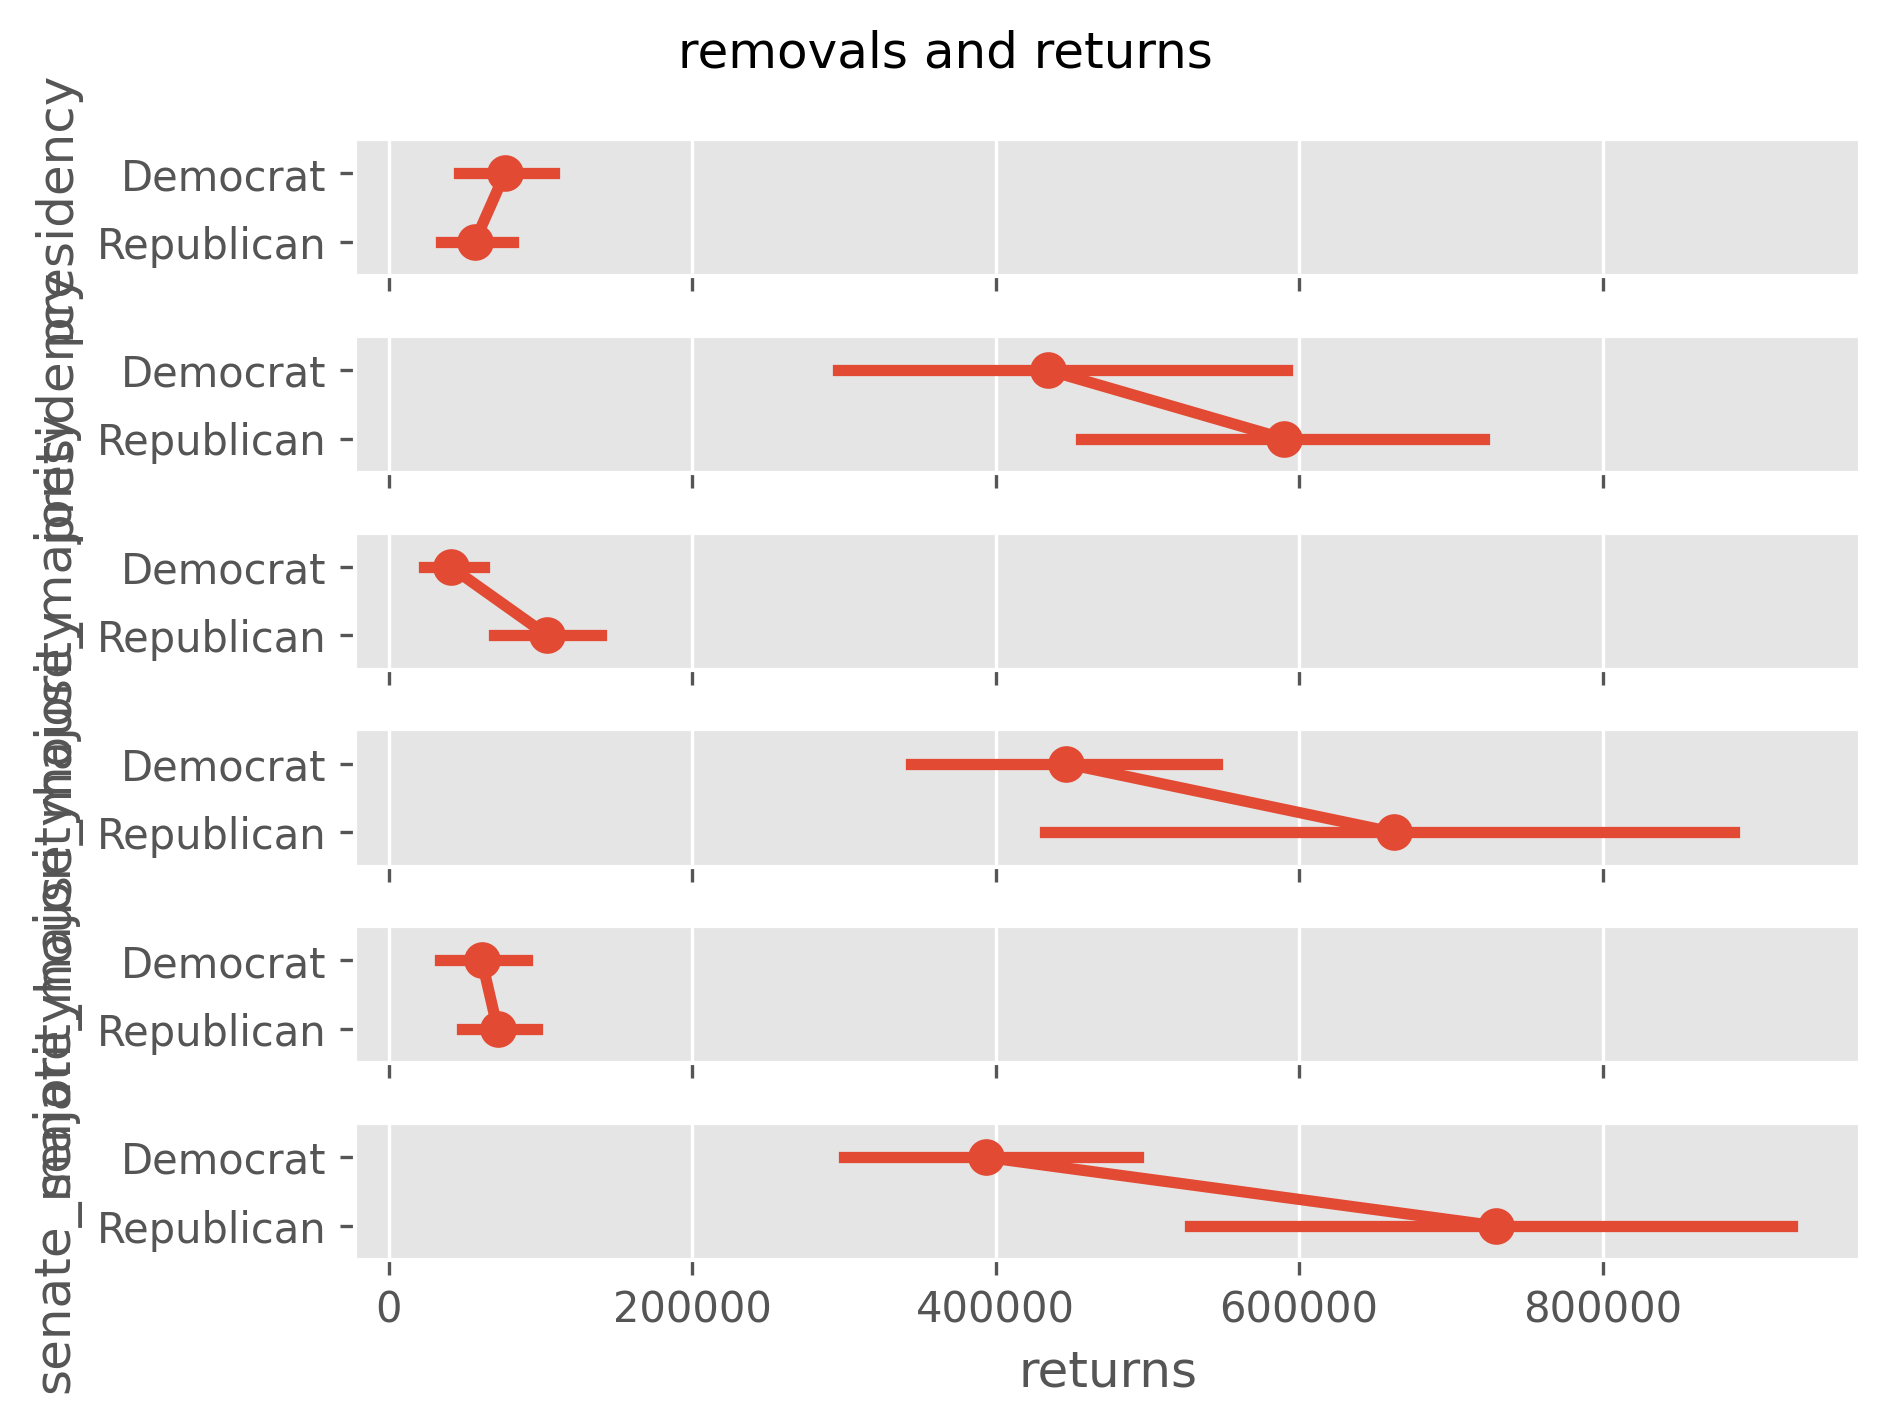

In [575]:
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True)

sns.pointplot(data=df, ax=axes[0], x="removals", y="presidency")
sns.pointplot(data=df, ax=axes[1], x="returns", y="presidency")

sns.pointplot(data=df, ax=axes[2], x="removals", y="house_majority")
sns.pointplot(data=df, ax=axes[3], x="returns", y="house_majority")

sns.pointplot(data=df, ax=axes[4], x="removals", y="senate_majority")
sns.pointplot(data=df, ax=axes[5], x="returns", y="senate_majority")

plt.suptitle("removals and returns")
plt.tight_layout()

These point in different directions.

-   when the president is democrat, there are more removals in general
-   when the house is republican, there are more removals in general
-   the only one which points the opposite way is democratic president.


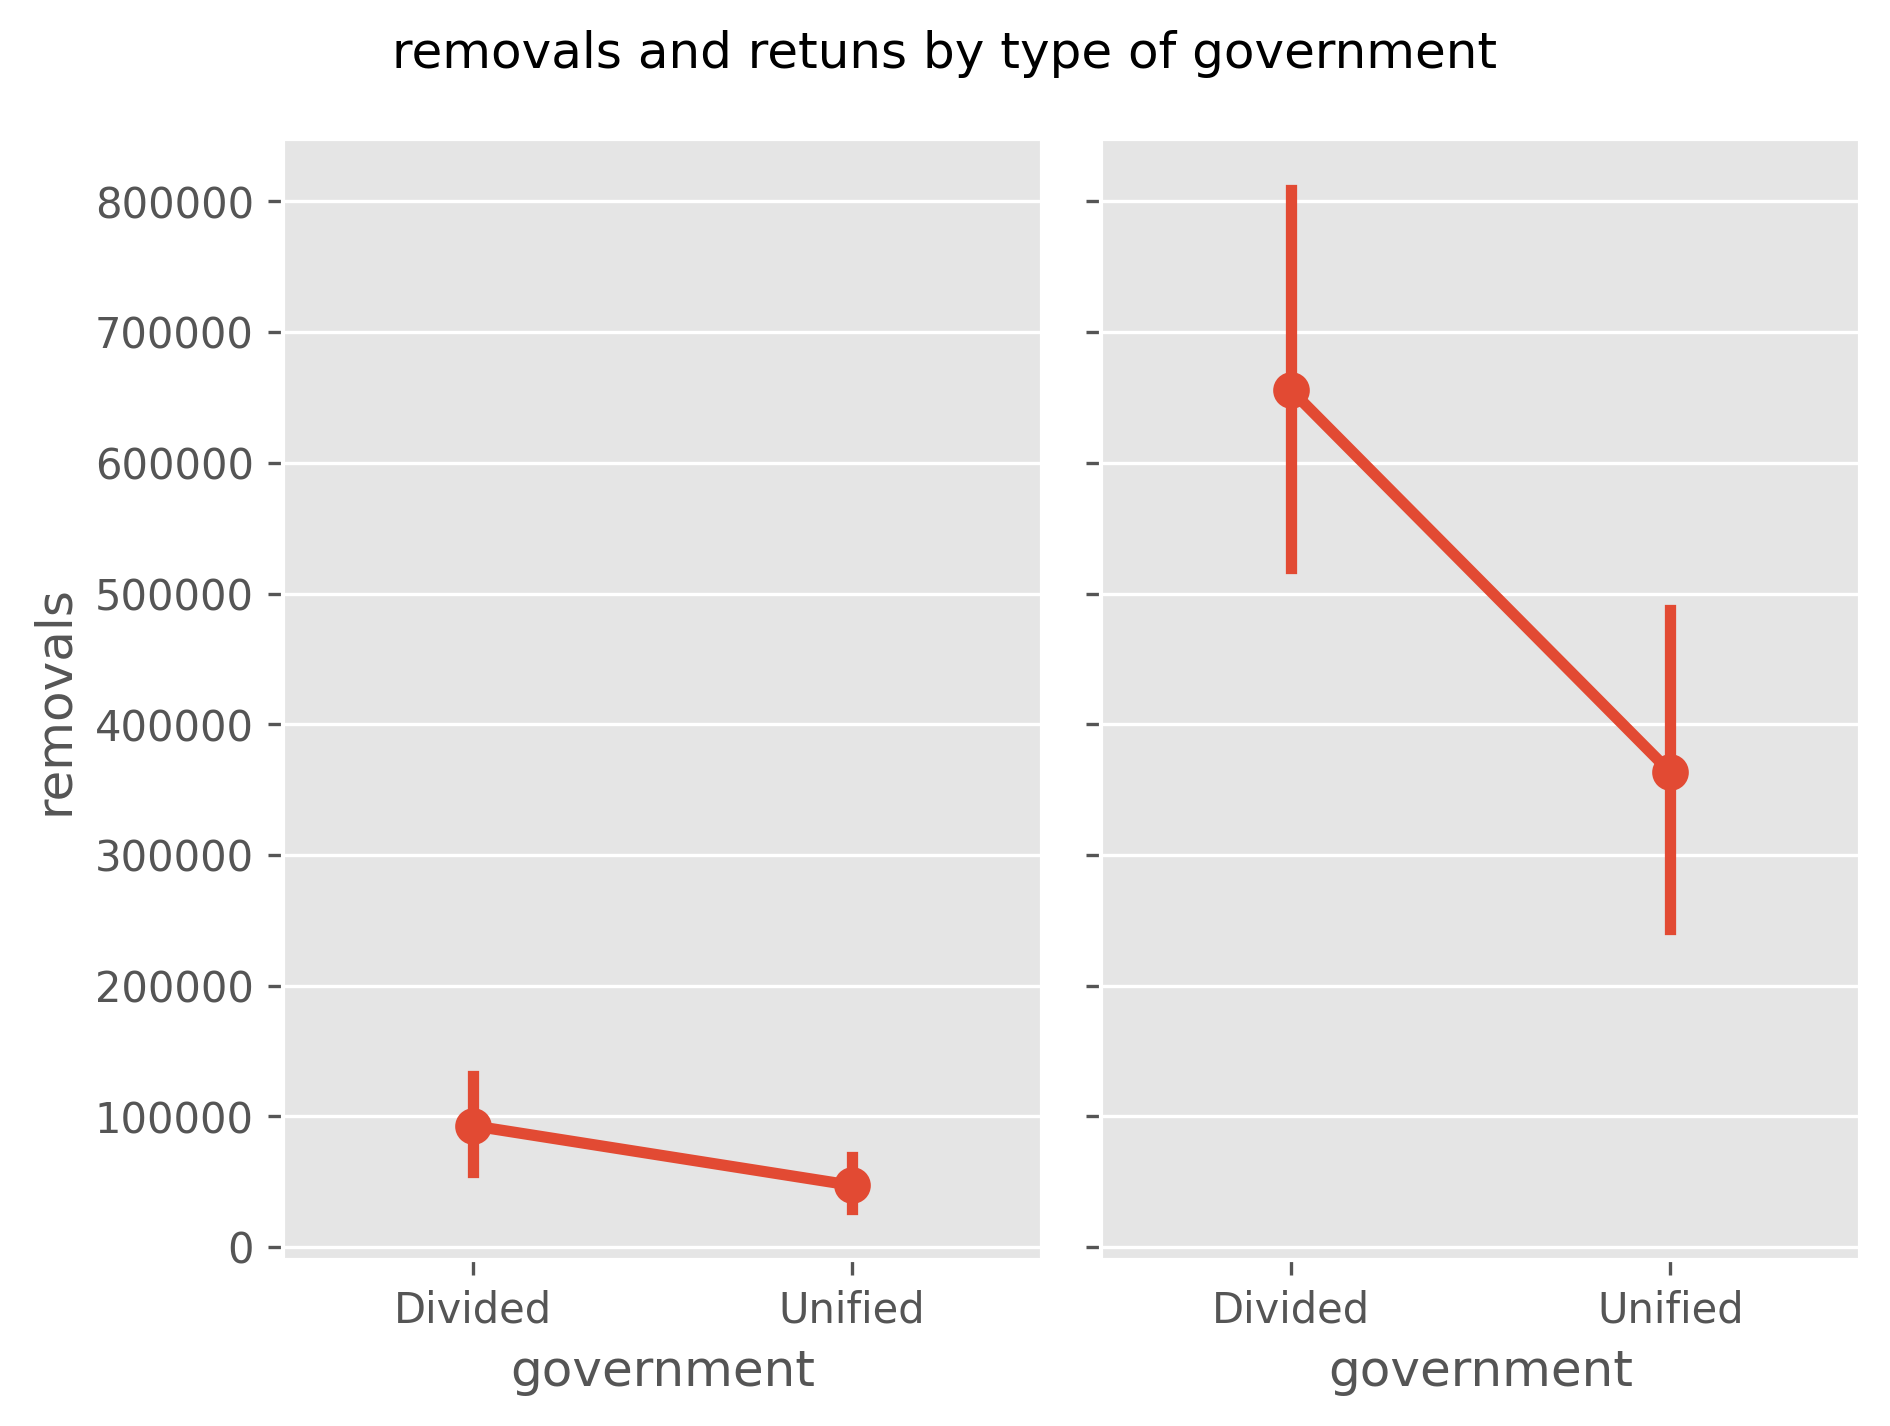

In [576]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

sns.pointplot(data=df, ax=axes[0], y="removals", x="government")
sns.pointplot(data=df, ax=axes[1], y="returns", x="government")

plt.suptitle("removals and retuns by type of government")
plt.tight_layout()

-   more returns when the government is divided
    -   TODO check what happens when segregated by how it is divided


TODO compare last 20 and 10 years. specific presidents


In [582]:
df[["removals", 'returns']].describe()

,removals,returns
count,126.00,91.00
mean,"66,088.51","507,966.53"
std,"112,785.81","496,079.44"
min,"1,630.00","6,531.00"
25%,"10,686.50","61,989.50"
50%,"18,953.50","276,297.00"
75%,"32,755.25","921,695.00"
max,"432,228.00","1,675,876.00"


In [ ]:
df.pivot_table(values=['removals', 'returns'], columns='presidency', aggfunc='mean')

/tmp/ipykernel_89759/3090070400.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(values=['removals', 'returns'], columns='presidency', aggfunc='mean')


presidency,Democrat,Republican
removals,"76,570.72","56,559.23"
returns,"434,260.92","590,242.56"


- removals are higher while the president is from the democratic party
- returns are higher when the president is from the republican party

In [584]:
df.pivot_table(values=['removals', 'returns'], columns='house_majority', aggfunc='mean')

/tmp/ipykernel_89759/1535936028.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(values=['removals', 'returns'], columns='house_majority', aggfunc='mean')


house_majority,Democrat,Republican
removals,"40,802.84","104,522.72"
returns,"446,251.52","662,254.04"


- removals are higher when the house majority is from the republican party. this is expressive.
- returns are higher when the house majority is from the democratic party.

In [585]:
df.pivot_table(values=['removals', 'returns'], columns='senate_majority', aggfunc='mean')

/tmp/ipykernel_89759/4049587246.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(values=['removals', 'returns'], columns='senate_majority', aggfunc='mean')


senate_majority,Democrat,Republican
removals,"61,256.66","71,753.43"
returns,"393,381.45","729,744.10"


- removals are higher when the senate majority is from the republican party.
- returns are higher when the senate majority is from the republican party. this is expressive

In [ ]:
df.pivot_table(values=['removals', 'returns'], columns='government', aggfunc='mean')

/tmp/ipykernel_89759/1789768387.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(values=['removals', 'returns'], columns='government', aggfunc='mean')


government,Divided,Unified
removals,"92,915.52","47,237.09"
returns,"655,769.36","363,376.80"


- removals are higher when the government is divided. this is expressive
- returns are higher when the government is divided. this is expressive

## Inferential statistics


### Test 1: removals presidency

In [590]:
cm = st.CompareMeans(
    st.DescrStatsW(df["removals"][df["presidency"] == "Democrat"]),
    st.DescrStatsW(df["removals"][df["presidency"] != "Democrat"]),
)

cm.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,2.001e+04,2.01e+04,0.995,0.322,-1.98e+04,5.98e+04


In [591]:
_, p, _ = cm.ttest_ind()
confint_low, confint_high = cm.tconfint_diff()
print(f"CI [{confint_low:.2f}, {confint_high:.2f}]")
print(f"p = {p:.3f}")

CI [-19810.04, 59833.02]
p = 0.322


### Test 2: removals house

In [592]:
st.CompareMeans(
    st.DescrStatsW(df["removals"][df["house_majority"] == "Democrat"]),
    st.DescrStatsW(df["removals"][df["house_majority"] != "Democrat"]),
).summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-6.372e+04,1.98e+04,-3.217,0.002,-1.03e+05,-2.45e+04


### Test 3: returns senate

In [596]:
st.CompareMeans(
    st.DescrStatsW(df["returns"].dropna()[df["senate_majority"] == "Democrat"]),
    st.DescrStatsW(df["returns"].dropna()[df["senate_majority"] != "Democrat"]),
).summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-3.364e+05,1.04e+05,-3.221,0.002,-5.44e+05,-1.29e+05


### Test 4: removals divided

In [597]:
st.CompareMeans(
    st.DescrStatsW(df["removals"][df["government"] == "Divided"]),
    st.DescrStatsW(df["removals"][df["government"] != "Divided"]),
).summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,4.568e+04,2.01e+04,2.275,0.025,5941.670,8.54e+04


## Bias and normative factors

if the majority is slim, is this important?

this is one data point in an extremely complicated system. correlation and causantion

this is a lot of abstraction through a long time with many factors. reducing the daat like this might give you quite wrong conclusions. people are paid millions to do this and they obviously do not get great results

how do they even know that undocumented people are leaving?

there are some clear events to be analysed here which i dont know about. the spikes in returns for instance

the difference in correlation and causation is especially important here where it is way too easy to say there is a difference. this can be used to say things like 'governments should be united', which would be an incorrect conclusion to take from this. maybe united governments happen in periods of progress or prosperity, or they have exceptionally good leaders. this simple correlational quantitative analysis might be enlightening in some way, but it is not enough to make grand claims. this can be a good starting point for a more sophisticated analysis, but it does not substitute one. 


## Conclusion
